In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
)

In [3]:
df= pd.read_csv("EMG_Features.csv")
df

X = df.drop(columns=['Target'])
y = df['Target']



print(y)
#Hago una división de datos 70-15-15
X_train, X_treinta, y_train, y_treinta = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
    )
X_val, X_test, y_val, y_test = train_test_split(
    X_treinta, y_treinta, test_size=0.50, random_state=42, stratify=y_treinta
)

# Pipeline de escalado y el PCA
pipeline_pca = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95))   #Para que nos de el 95% de varianza
])

# Ajustar EL PIPELINE con train, se hace solo con este porque como sabemos se puede sesgar
pipeline_pca.fit(X_train)

# Transformar cada conjunto
X_train_pca = pipeline_pca.transform(X_train)
X_val_pca   = pipeline_pca.transform(X_val)
X_test_pca  = pipeline_pca.transform(X_test)

# Varianza explicada
pca = pipeline_pca.named_steps['pca']
print("Varianza explicada por cada componente:")
print(pca.explained_variance_ratio_)

print("\nVarianza explicada acumulada:",
      pca.explained_variance_ratio_.sum())

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
12413    1.0
12414    1.0
12415    1.0
12416    1.0
12417    1.0
Name: Target, Length: 12418, dtype: float64
Varianza explicada por cada componente:
[0.37144445 0.20124968 0.14981568 0.08190279 0.05673402 0.04973711
 0.03248761 0.02660736]

Varianza explicada acumulada: 0.9699787024598474


In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Definir el espacio de búsqueda
param_grid = {
    'C': [0.1, 1, 10, 100, 300],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
    'kernel': ['rbf']
}

# Modelo base
svm_base = SVC(probability=True)

# GridSearch
grid = GridSearchCV(
    estimator=svm_base,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Entrenar
grid.fit(X_train_pca, y_train)

print("Mejores hiperparámetros:", grid.best_params_)
print("Mejor score de entrenamiento:", grid.best_score_)


Mejores hiperparámetros: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Mejor score de entrenamiento: 0.9425903806997263


In [5]:
svm_best = grid.best_estimator_

# Validación
y_val_pred = svm_best.predict(X_val_pca)
val_acc = accuracy_score(y_val, y_val_pred)
print("Accuracy validación:", val_acc)

# Test
y_test_pred = svm_best.predict(X_test_pca)
test_acc = accuracy_score(y_test, y_test_pred)
print("Accuracy test:", test_acc)


Accuracy validación: 0.9543746645195921
Accuracy test: 0.9447128287707998


In [7]:
y_prob = svm_best.predict_proba(X_test_pca)[:, 1]


In [12]:
print("\nReporte de clasificación (test):")
print(classification_report(y_test, y_test_pred))

print("\nMatriz de confusión (test):")
print(confusion_matrix(y_test, y_test_pred))


Reporte de clasificación (test):
              precision    recall  f1-score   support

         0.0       0.93      0.96      0.95       958
         1.0       0.96      0.93      0.94       905

    accuracy                           0.94      1863
   macro avg       0.95      0.94      0.94      1863
weighted avg       0.94      0.94      0.94      1863


Matriz de confusión (test):
[[919  39]
 [ 64 841]]


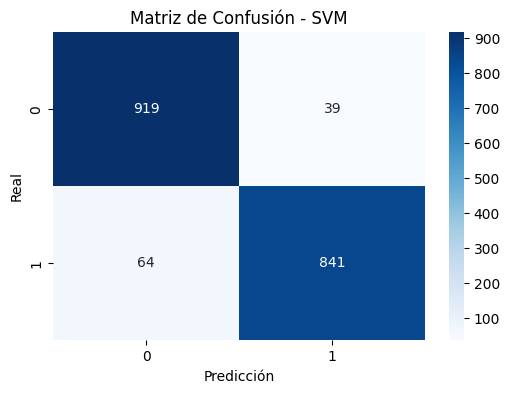

In [8]:
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - SVM")
plt.show()

In [9]:
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_test_pred))


Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.93      0.96      0.95       958
         1.0       0.96      0.93      0.94       905

    accuracy                           0.94      1863
   macro avg       0.95      0.94      0.94      1863
weighted avg       0.94      0.94      0.94      1863



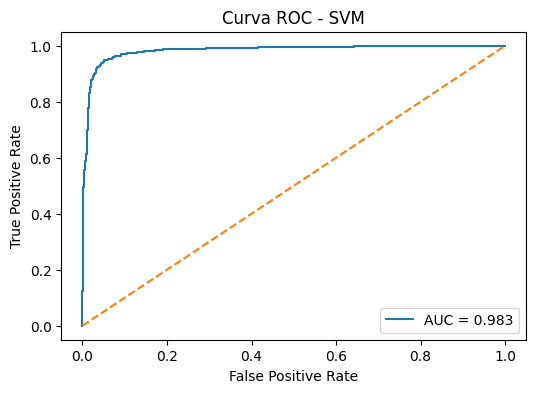

In [11]:
y_prob = svm_best.predict_proba(X_test_pca)[:, 1]

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - SVM")
plt.legend()
plt.show()